# 使用xgboost进行预测

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import os

In [7]:
# 股票列表

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',]  # 科技
tickers += ['JPM', 'BAC', 'C', 'WFC', 'GS',]            # 金融
tickers += ['JNJ', 'PFE', 'MRK', 'ABBV', 'BMY',]         # 医药
tickers += ['XOM', 'CVX', 'COP', 'SLB', 'BKR',]          # 能源
tickers += ['DIS', 'NFLX', 'CMCSA', 'NKE', 'SBUX',]      # 消费
tickers += ['CAT', 'DE', 'MMM', 'GE', 'HON']            # 工业

# 参数
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [25, 50, 100, 200]
}

num_features_to_keep = 9

In [8]:
def get_stock_data(ticker):
    data = yf.download(ticker, start='2018-12-01', end='2024-01-01')
    # 日期
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day

    close = data['Close'].shift(1)
    # 移动平均线
    data['MA5'] = close.rolling(window=5).mean()
    data['MA10'] = close.rolling(window=10).mean()
    data['MA20'] = close.rolling(window=20).mean()

    # RSI
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    data.loc[data.index >= RSI.index[0], 'RSI'] = RSI

    # MACD
    exp1 = close.ewm(span=12, adjust=False).mean()
    exp2 = close.ewm(span=26, adjust=False).mean()
    MACD = exp1 - exp2
    data.loc[data.index >= MACD.index[0], 'MACD'] = MACD

    # VWAP
    data['VWAP'] = (close * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Bollinger Bands
    period = 20
    data['SMA'] = close.rolling(window=period).mean()
    data['Std_dev'] = close.rolling(window=period).std()
    data['Upper_band'] = data['SMA'] + 2 * data['Std_dev']
    data['Lower_band'] = data['SMA'] - 2 * data['Std_dev']

    # 相对大盘的表现
    benchmark_data = yf.download('SPY', start='2019-01-01', end='2024-01-01')['Close'].shift(1)
    data['Relative_Performance'] = (close / benchmark_data.values) * 100

    # 价格变化率
    data['ROC'] = (close.pct_change(periods=1)) * 100

    # 平均变化率
    high_low_range = data['High'].shift(1) - data['Low'].shift(1)
    high_close_range = abs(data['High'].shift(1) - close.shift(1))
    low_close_range = abs(data['Low'].shift(1) - close.shift(1))
    true_range = pd.concat([high_low_range, high_close_range, low_close_range], axis=1).max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    returns = close.pct_change().dropna()
    risk_free_rate = 0.01  # 假设无风险利率为1%
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    data['Sharpe_Ratio'] = sharpe_ratio

    covariance = returns.cov(benchmark_data.pct_change().dropna())
    benchmark_variance = benchmark_data.pct_change().dropna().var()
    beta = covariance / benchmark_variance
    data['Beta'] = beta

    data['Open_yes'] = data['Open'].shift(1)
    data['Close_yes'] = data['Close'].shift(1)
    data['High_yes'] = data['High'].shift(1)
    data['Low_yes'] = data['Low'].shift(1)

    data = data.dropna()
    return data

# 获取所有股票数据
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}
stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'AAPL':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-31   41.527500   42.250000   41.139999   41.610001   39.832802   
 2019-02-01   41.740002   42.244999   41.482498   41.630001   39.851955   
 2019-02-04   41.852501   42.915001   41.820000   42.812500   40.983948   
 2019-02-05   43.215000   43.770000   43.087502   43.544998   41.685158   
 2019-02-06   43.662498   43.892502   43.212502   43.560001   41.699528   
 ...                ...         ...         ...         ...         ...   
 2023-12-22  195.179993  195.410004  192.970001  193.600006  193.091385   
 2023-12-26  193.610001  193.889999  192.830002  193.050003  192.542816   
 2023-12-27  192.490005  193.500000  191.089996  193.149994  192.642548   
 2023-12-28  194.139999  194.660004  193.169998  193.580002  193.071426   
 2023-12-29  193.899994  194.399994  191.729996  192.529999  192.024185   
 
               

In [9]:
def format_feature(data):
    features = ['Volume', 'Year', 'Month', 'Day', 'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'Open', 'Close', 'High', 'Low'\
                , 'VWAP', 'SMA', 'Std_dev', 'Upper_band', 'Lower_band', 'Relative_Performance', 'ATR']
    X = data[features]
    y = data['Close'].pct_change()
    # y = (data['Close'] - data['Open'])
    X = X.iloc[1:]
    y = y.iloc[1:]
    return X, y

# 格式化数据
stock_features = {ticker: format_feature(data) for ticker, data in stock_data.items()}
print("stock_features:", stock_features)

stock_features: {'AAPL': (               Volume  Year  Month  Day         MA5        MA10        MA20  \
Date                                                                          
2019-02-01  130672400  2019      2    1   40.021500   39.325750   38.494625   
2019-02-04  125982000  2019      2    4   40.459500   39.592250   38.798750   
2019-02-05  144406400  2019      2    5   41.207000   39.953000   39.086125   
2019-02-06  112958400  2019      2    6   42.182000   40.475000   39.414250   
2019-02-07  126966800  2019      2    7   42.631500   40.983000   39.707875   
...               ...   ...    ...  ...         ...         ...         ...   
2023-12-22   37122800  2023     12   22  195.982001  195.958002  193.487000   
2023-12-26   28919300  2023     12   26  195.188000  195.747002  193.668501   
2023-12-27   48087700  2023     12   27  194.620001  195.734003  193.831501   
2023-12-28   34049900  2023     12   28  193.862000  195.578001  193.969001   
2023-12-29   42628800  202

In [10]:
def feature_selection_for_stocks(stock_features, best_params, num_features_to_keep=8):
    feature_importances_all = {}
    stock_features_selected = {}

    # 训练模型，获得所有股票的特征重要度
    for ticker, (X, y) in stock_features.items():
        params = best_params

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **params)
        xgb_model.fit(X, y)
        feature_importances = xgb_model.feature_importances_

        feature_importance_list = [(feature, importance) for feature, importance in zip(X.columns, feature_importances)]
        feature_importance_list.sort(key=lambda x: x[1], reverse=True)
        
        feature_importances_all[ticker] = feature_importance_list

    # 打印每支股票的特征重要度排名
    for ticker, importance_list in feature_importances_all.items():
        # print(f"Stock: {ticker}")
        for feature, importance in importance_list:
            pass
            # print(f"Importance of {feature}: {importance:.2f}")
    # print(feature_importances_all)
    feature_importance_totals = {}
    # 平均值
    for stock, feature_importances in feature_importances_all.items():
        for feature, importance in feature_importances:
            if feature in feature_importance_totals:
                feature_importance_totals[feature] += importance
            else:
                feature_importance_totals[feature] = importance
    num_stocks = len(feature_importances_all)
    average_feature_importances = {feature: importance / num_stocks for feature, importance in feature_importance_totals.items()}
    # average_feature_importances = sorted(average_feature_importances, key=lambda x: x[1], reverse=True)
    for feature, avg_importance in average_feature_importances.items():
        print(f"Average importance of {feature} across all stocks: {avg_importance:.2f}")

    # 只保留重要的特征
    importance_list = sorted(average_feature_importances.items(), key=lambda x: x[1], reverse=True)
    importance_list = importance_list[:num_features_to_keep]
    important_features = [feature for feature, importance in importance_list[:num_features_to_keep]]
    print(f"Selected the top{num_features_to_keep} stocks: {important_features}")
    for stock in stock_features:
        # X_selected = stock_features[stock][0]
        stock_features_selected[stock] = stock_features[stock]
    return stock_features_selected

# 进行特征选择
temp_params = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 50, 'subsample': 0.6}
stock_features_selected = feature_selection_for_stocks(stock_features, temp_params, num_features_to_keep)

Average importance of Close across all stocks: 0.08
Average importance of ATR across all stocks: 0.07
Average importance of Low across all stocks: 0.07
Average importance of Lower_band across all stocks: 0.06
Average importance of Upper_band across all stocks: 0.06
Average importance of Open across all stocks: 0.06
Average importance of SMA across all stocks: 0.06
Average importance of MACD across all stocks: 0.05
Average importance of Relative_Performance across all stocks: 0.05
Average importance of VWAP across all stocks: 0.05
Average importance of RSI across all stocks: 0.05
Average importance of Std_dev across all stocks: 0.05
Average importance of MA20 across all stocks: 0.04
Average importance of Volume across all stocks: 0.04
Average importance of High across all stocks: 0.04
Average importance of MA5 across all stocks: 0.04
Average importance of MA10 across all stocks: 0.04
Average importance of Month across all stocks: 0.03
Average importance of Day across all stocks: 0.03
Av

In [11]:
def train_model(X, y):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    tscv = TimeSeriesSplit(n_splits=2)
    best_score = None
    best_params = None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        current_best_params = grid_search.best_params_

        model = xgb.XGBRegressor(objective='reg:squarederror', seed=2, **current_best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        if best_score is None or score < best_score:
            best_score = score
            best_params = current_best_params

    return best_params

# 调参并获取最优参数组合
best_params = {ticker: train_model(X, y) for ticker, (X, y) in stock_features_selected.items()}

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits


In [12]:
best_params

{'AAPL': {'colsample_bytree': 0.9,
  'learning_rate': 0.001,
  'max_depth': 12,
  'n_estimators': 50,
  'subsample': 1.0}}

Running prediction for the stock AAPL...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.074222               3.679410 -3.605188
1                  0.100716               0.408887 -0.308171
2                  0.040763               0.445641 -0.404878
3                 -0.050330               2.111229 -2.161559
4                 -0.093564              -0.059931 -0.033633
..                      ...                    ...       ...
242               -1.039826              -0.554750 -0.485077
243               -0.964700              -0.284092 -0.680608
244               -0.415464               0.051795 -0.467260
245               -0.549117               0.222629 -0.771746
246               -0.858050              -0.542413 -0.315638

[247 rows x 3 columns]
Naive strategy earn rate: 45.15899884387806 %
Xgboost strategy earn rate: 43.09817402634702 %


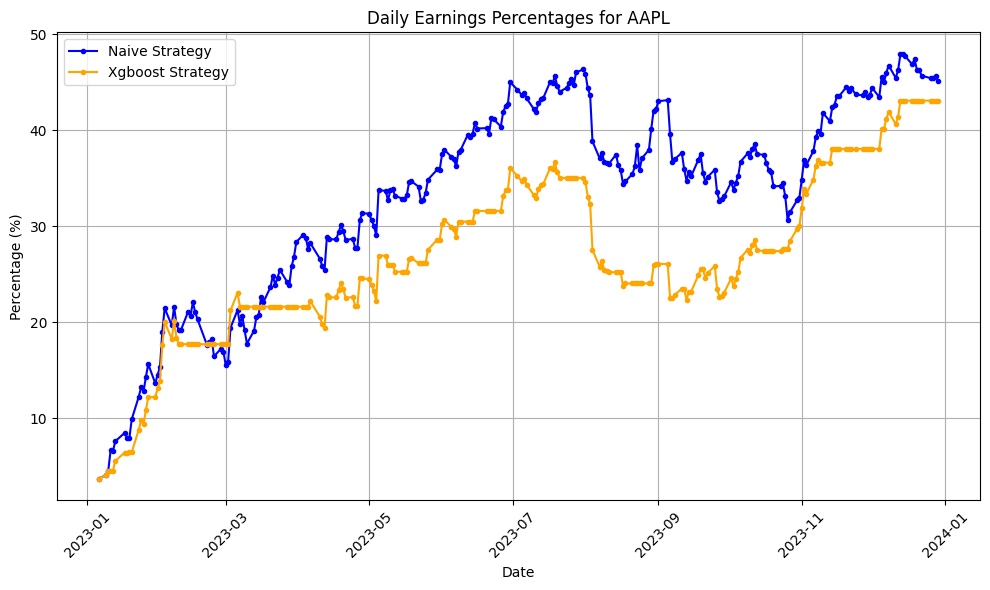

{'AAPL': {'2023-01-06 00:00:00': 0.0007422247435897589,
  '2023-01-09 00:00:00': 0.001007159473374486,
  '2023-01-10 00:00:00': 0.0004076302284374833,
  '2023-01-11 00:00:00': -0.0005032991175539792,
  '2023-01-12 00:00:00': -0.0009356388472951949,
  '2023-01-13 00:00:00': 0.0015848538605496287,
  '2023-01-17 00:00:00': 0.000964318634942174,
  '2023-01-18 00:00:00': -0.0009272259194403887,
  '2023-01-19 00:00:00': 8.839766815071926e-05,
  '2023-01-20 00:00:00': -0.0015566759975627065,
  '2023-01-23 00:00:00': 0.0026094273198395967,
  '2023-01-24 00:00:00': 0.0023984755389392376,
  '2023-01-25 00:00:00': 0.0007811218383722007,
  '2023-01-26 00:00:00': 0.0005537873366847634,
  '2023-01-27 00:00:00': 0.003225349122658372,
  '2023-01-30 00:00:00': -0.0006954999989829957,
  '2023-01-31 00:00:00': 0.0027819371316581964,
  '2023-02-01 00:00:00': 0.0016866362420842052,
  '2023-02-02 00:00:00': 0.010240315459668636,
  '2023-02-03 00:00:00': 0.03326152265071869,
  '2023-02-06 00:00:00': 0.004088

In [13]:
def predict_and_plot(ticker, data, X, y, best_params):
    print(f"Running prediction for the stock {ticker}...")
    predictions = []
    test_indices = []
    predict_percentages = []
    actual_percentages = []
    num_boost_round = best_params.pop('n_estimators')
    params = best_params

    start = int((len(data) - 1) * 0.8)
    end = (len(data) - 2)
    tune_length = int((len(data) - 1) * 0.05)

    evals_result = {}

    for i in range(start, end):
        # 第一轮使用80%数据训练
        if i == start:
            X_train = X.iloc[:i+1]
            y_train = y.iloc[:i+1]
            dtrain = xgb.DMatrix(X_train, label=y_train)
            model = xgb.train(params, dtrain, num_boost_round)
        # 之后每一轮使用5%数据微调
        else:
            X_train_new = X.iloc[i+1-tune_length:i+1]
            y_train_new = y.iloc[i+1-tune_length:i+1]
            dnew = xgb.DMatrix(X_train_new, label=y_train_new)
            model = xgb.train(params, dnew, num_boost_round, xgb_model=model)
            
        # print(f"Epoch {i-start+1}, Train Loss: {evals_result['train']['rmse'][-1]}")

        # 对后面一天的数据进行预测
        X_test = X.iloc[i+1:i+2]
        y_test = y.iloc[i+1:i+2]
        dtest = xgb.DMatrix(X_test)
        predicted_values = model.predict(dtest)

        predictions.append((1+predicted_values[0])*X['Close'].iloc[i])
        test_indices.append(y_test.index[0])

        predict_percentages.append(predicted_values[0]*100)
        actual_percentages.append(y.iloc[i+1]*100)

    delta = [p - a for p, a in zip(predict_percentages, actual_percentages)]
    result = pd.DataFrame({
        'predict_percentages(%)': predict_percentages,
        'actual_percentages(%)': actual_percentages,
        'delta(%)': delta
    })
    print(result)

    # 简单策略的收益率
    print("Naive strategy earn rate:", sum(actual_percentages), "%")

    # xgboost策略的收益率
    xgb_strategy_earn = []
    for i, predict in enumerate(predict_percentages):
        if predict > 0:
            xgb_strategy_earn.append(actual_percentages[i])
        else:
            xgb_strategy_earn.append(0)
    print("Xgboost strategy earn rate:", sum(xgb_strategy_earn), "%")

    # 绘制累积收益率曲线
    cumulative_naive_percentage = np.cumsum(actual_percentages)
    cumulative_xgb_percentage = np.cumsum(xgb_strategy_earn)
    plt.figure(figsize=(10, 6))
    plt.plot(test_indices, cumulative_naive_percentage, marker='o', markersize=3, linestyle='-', color='blue', label='Naive Strategy')
    plt.plot(test_indices, cumulative_xgb_percentage, marker='o', markersize=3, linestyle='-', color='orange', label='Xgboost Strategy')
    plt.title(f'Daily Earnings Percentages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if not os.path.exists('pic'):
        os.makedirs('pic')
    plt.savefig(f'pic/XGBoost/{ticker}.png')
    
    plt.show()

    predict_result = {str(date): pred/100 for date, pred in zip(test_indices, predict_percentages)}
    return predict_result

# 对所有股票进行预测和绘图
# best_params = {'TSLA': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 4,
#   'n_estimators': 200,
#   'subsample': 0.8},
#  'AAPL': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 6,
#   'n_estimators': 200,
#   'subsample': 0.6}}
all_predictions = {}
for ticker in tickers:
    data = stock_data[ticker]
    X, y = stock_features_selected[ticker]
    params = best_params[ticker]
    predict_result = predict_and_plot(ticker, data, X, y, params)
    all_predictions[ticker] =  predict_result
all_predictions

# 使用xgboost的预测结果设计策略

In [13]:
start = (int((len(data) - 1) * 0.8)+1)
start_test_date = y.iloc[start:start+1].index[0]
end = (len(data) - 2)
end_test_date = y.iloc[end:end+1].index[0]
# start_test_date = start_test_date.to_pydatetime()
# end_test_date = end_test_date.to_pydatetime()
print(end_test_date)

2023-12-29 00:00:00


In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

class MyStrategy:
    def __init__(self, symbols, start_date, end_date, model_predict={}):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.model_predict = model_predict
        self.trade_log = []
        self.Initialize()

    def Initialize(self):
        self.cash = 100000
        self.risk_free_rate = 0
        self.rebalance_time = 1
        self.last_rebalance = self.start_date
        self.portfolio = {}
        self.prev_price = {}
        self.data = self.download_data()
        
    def download_data(self):
        symbols = self.symbols + ['SPY'] # download the benchmark data
        data = yf.download(symbols, start=self.start_date, end=self.end_date+timedelta(days=5))['Adj Close']
        return data

    def calculate_sharpe_ratio(self, returns):
        excess_returns = returns - self.risk_free_rate / 252
        std = excess_returns.std()
        return np.sqrt(252) * (excess_returns.mean() / std) if std != 0 else 0

    def calculate_beta(self, stock_returns, benchmark_returns):
        assert len(stock_returns) == len(benchmark_returns)
        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        return covariance_matrix[0, 1] / np.var(benchmark_returns)

    def is_bull_market(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        return recent_market_returns.mean() > 0

    def adjust_position(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        market_mean_return = recent_market_returns.mean()
        if math.isnan(market_mean_return):
            return 1.0
        elif market_mean_return > 0:
            return 1.0
        elif market_mean_return > -0.02:
            return 0.8
        else:
            # print(market_mean_return)
            return max(0.8 - (market_mean_return+0.02)*10, 0)

    def rebalance(self, current_date):
        pass

    def run_backtest(self):
        # rebalance_dates = pd.date_range(self.start_date, self.end_date, freq=f'{self.rebalance_time}D')
        trading_days = self.data.index
        rebalance_dates = trading_days[::self.rebalance_time]
        portfolio_values = []
        # print(rebalance_dates)
        for date in self.data.index:
            if date in rebalance_dates and date != rebalance_dates[-1]:
                # print("before:", self.portfolio)
                # print(date)
                self.rebalance(date)
                # print("after:", self.portfolio)
            # print("cash:", self.cash)
            # print("date:", date)
            portfolio_value = self.cash + sum(self.data[symbol][date] * shares for symbol, shares in self.portfolio.items())
            # print(portfolio_value)
            portfolio_values.append(portfolio_value)
        
        return portfolio_values

    def plot_portfolio_value(self):
        portfolio_values = self.run_backtest()
        portfolio_series = pd.Series(portfolio_values, index=self.data.index)
        portfolio_series.plot(title="Portfolio Value Over Time", figsize=(10, 6))
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.grid(True)
        plt.show()

        print("Initial funding:", 100000)
        print("Final funding:", portfolio_series.iloc[-1])
        print("Yield rate:", (portfolio_series.iloc[-1] - 100000) / 100000 * 100, "%")



[*********************100%%**********************]  31 of 31 completed


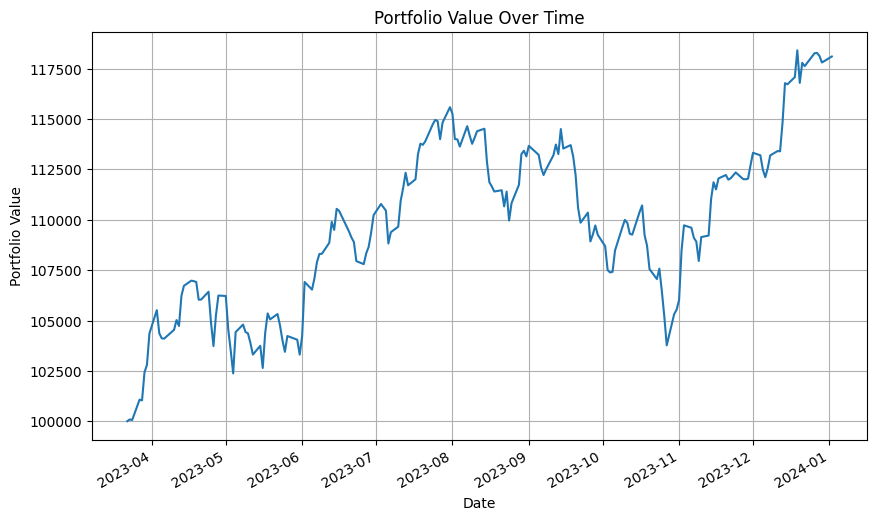

Initial funding: 100000
Final funding: 118103.13306236267
Yield rate: 18.10313306236267 %


In [16]:
class NaiveStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date):
        super().__init__(symbols, start_date, end_date)
        
    def rebalance(self, current_date):
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        self.portfolio = {}
        
        selected_symbols = self.symbols
        
        # buy the selected stocks using all the cash
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            self.portfolio[symbol] = math.floor((self.cash / num_stocks) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

naive_strategy = NaiveStrategy(symbols=tickers, start_date=start_test_date, end_date=end_test_date)
naive_strategy.plot_portfolio_value()

[*********************100%%**********************]  31 of 31 completed


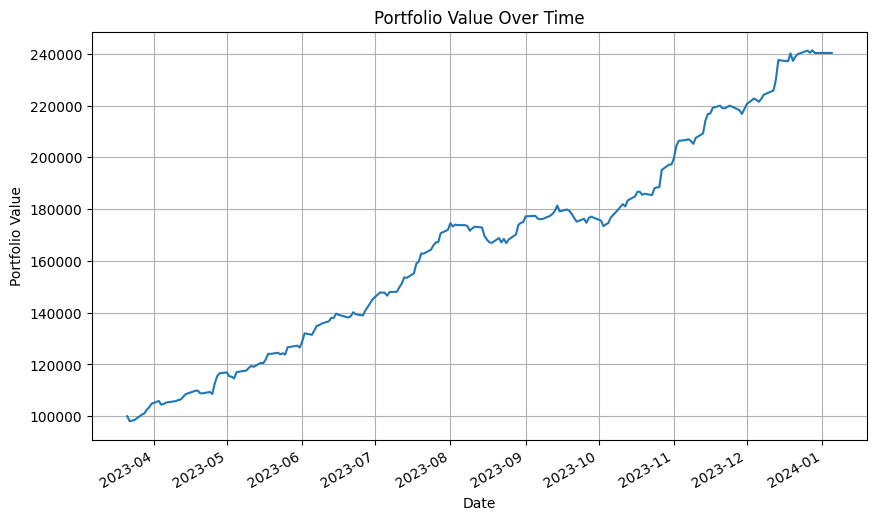

Initial funding: 100000
Final funding: 240352.72121810913
Yield rate: 140.35272121810914 %


In [17]:
 class ShortStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date, model_predict):
        super().__init__(symbols, start_date, end_date, model_predict)
    
    def rebalance(self, current_date):

        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        
        # Clear current portfolio
        previous_portfolio = self.portfolio.copy()
        self.portfolio = {}
        
        # calculate the sharpe ratio and the beta value of every stock
        sharpes = {}
        betas = {}
        for symbol in self.symbols:
            hist = self.data[symbol][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=365))]
            returns = hist.pct_change().dropna()
            sharpes[symbol] = self.calculate_sharpe_ratio(returns)
            
        weights = {}
        selected_symbols = []
        current_date_index = self.data.index.get_loc(current_date)
        tomorrow = self.data.index[current_date_index + 1]
        # print("tomorrow:", tomorrow)
        for symbol, model_predict in self.model_predict.items():
            # print(model_predict)
            if (tomorrow > self.end_date):
                return 
            model_predict_tomorrow = model_predict[str(tomorrow)]
            # print("date:", current_date, "symbol:", symbol, "predict:", model_predict_tomorrow)
            if model_predict_tomorrow > 0:
                selected_symbols.append(symbol)

        for symbol in selected_symbols:
            if sharpes[symbol] < -0.5:
                selected_symbols.remove(symbol)
        
        
        # Buy the selected stocks using all the cash with stop loss
        for symbol in self.symbols:
            # Check stop loss condition using previous portfolio
            if self.prev_price:
                prev_price = self.prev_price[symbol]
                current_price = self.data[symbol][current_date]
                if (current_price - prev_price) / prev_price < -0.1: # The stop loss is set to 10%
                    if symbol in selected_symbols:
                        selected_symbols.remove(symbol) # Skip buying this stock

        # set the weights for selected symbols
        weights = {}
        for symbol, model_predict in self.model_predict.items():
            model_predict_tomorrow = model_predict[str(tomorrow)]
            if not symbol in selected_symbols:
                continue
            weights[symbol] = model_predict_tomorrow
            
        weight_sum = sum(weights.values())
        weights = {key: value / weight_sum for key, value in weights.items()}
        
        # buy the selected stocks using all the cash
        position = self.adjust_position(current_date)
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            symbol_weight = weights[symbol]
            self.portfolio[symbol] = math.floor((self.cash * position * symbol_weight) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

        position_change = {}
        for symbol in self.symbols:
            previous_shares = previous_portfolio.get(symbol, 0)
            current_shares = self.portfolio.get(symbol, 0)
            change = current_shares - previous_shares
            if change != 0:
                position_change[symbol] = change

        if not self.trade_log:
            earnings_per_stock = {}
        else:
            earnings_per_stock = self.trade_log[-1]['earnings_per_stock'].copy()
            # print(earnings_per_stock)
        for symbol in self.symbols:
            if symbol in previous_portfolio:
                # print(previous_portfolio, symbol)
                # print(self.prev_price)
                prev_price = self.prev_price[symbol]
                curr_price = self.data[symbol][current_date]
                hold = previous_portfolio[symbol]
                if symbol not in earnings_per_stock.keys():
                    # print(1)
                    # print(symbol)
                    earnings_per_stock[symbol] = (curr_price - prev_price) * hold
                else:
                    # print(2)
                    earnings_per_stock[symbol] += (curr_price - prev_price) * hold
        # print("after:", earnings_per_stock)

        self.prev_price = {}
                
        for symbol in self.symbols:
            self.prev_price[symbol] = self.data[symbol][current_date]
            # print(self.prev_price[symbol])

        # record the log
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        if self.trade_log:
            previous_balance = self.trade_log[-1]['balance']
        else:
            previous_balance = 100000
        trade_record = {
            'date': current_date,
            'balance': portfolio_value + self.cash,
            'earning': portfolio_value + self.cash - previous_balance,
            'portfolio': self.portfolio.copy(),
            'change': position_change,
            'earnings_per_stock': earnings_per_stock,
        }
        self.trade_log.append(trade_record)
        # print(self.trade_log)
            
xgb_strategy = ShortStrategy(symbols=tickers, start_date=datetime(2023, 3, 21), end_date=datetime(2024, 1, 1), model_predict=all_predictions)
xgb_strategy.plot_portfolio_value()

In [18]:
for record in xgb_strategy.trade_log:
    print(f"Date: {record['date']}")
    print(f"Balance: {record['balance']:.2f}")
    print(f"Earning: {record['earning']:.2f}")
    print("Portfolio:")
    for symbol, shares in record['portfolio'].items():
        print(f"  {symbol}: {shares} shares")
    print("Change:")
    for symbol, shares in record['change'].items():
        print(f"  {symbol}: {shares} shares")
    print("Earnings_per_stock:")
    for symbol, earn in record['earnings_per_stock'].items():
        print(f"  {symbol}: {earn}")
    print("-" * 40)


Date: 2023-03-21 00:00:00
Balance: 100000.00
Earning: 0.00
Portfolio:
  AAPL: 20 shares
  MSFT: 5 shares
  GOOGL: 14 shares
  AMZN: 35 shares
  TSLA: 26 shares
  JPM: 3 shares
  BAC: 438 shares
  GS: 11 shares
  PFE: 1 shares
  MRK: 46 shares
  ABBV: 13 shares
  BMY: 70 shares
  XOM: 112 shares
  CVX: 8 shares
  COP: 223 shares
  BKR: 105 shares
  DIS: 10 shares
  NFLX: 1 shares
  CMCSA: 128 shares
  SBUX: 20 shares
  CAT: 27 shares
  DE: 13 shares
  HON: 5 shares
Change:
  AAPL: 20 shares
  MSFT: 5 shares
  GOOGL: 14 shares
  AMZN: 35 shares
  TSLA: 26 shares
  JPM: 3 shares
  BAC: 438 shares
  GS: 11 shares
  PFE: 1 shares
  MRK: 46 shares
  ABBV: 13 shares
  BMY: 70 shares
  XOM: 112 shares
  CVX: 8 shares
  COP: 223 shares
  BKR: 105 shares
  DIS: 10 shares
  NFLX: 1 shares
  CMCSA: 128 shares
  SBUX: 20 shares
  CAT: 27 shares
  DE: 13 shares
  HON: 5 shares
Earnings_per_stock:
----------------------------------------
Date: 2023-03-22 00:00:00
Balance: 98077.35
Earning: -1922.65
P

In [19]:
import pickle
for ticker, predictions in all_predictions.items():
  file_path = os.path.join('prediction/XGBoost', f'{ticker}_predictions.pkl')
  with open(file_path, 'wb') as file:
    pickle.dump(predictions, file)
    print(f'Saved predictions for {ticker} to {file_path}')

Saved predictions for AAPL to prediction/XGBoost\AAPL_predictions.pkl
Saved predictions for MSFT to prediction/XGBoost\MSFT_predictions.pkl
Saved predictions for GOOGL to prediction/XGBoost\GOOGL_predictions.pkl
Saved predictions for AMZN to prediction/XGBoost\AMZN_predictions.pkl
Saved predictions for TSLA to prediction/XGBoost\TSLA_predictions.pkl
Saved predictions for JPM to prediction/XGBoost\JPM_predictions.pkl
Saved predictions for BAC to prediction/XGBoost\BAC_predictions.pkl
Saved predictions for C to prediction/XGBoost\C_predictions.pkl
Saved predictions for WFC to prediction/XGBoost\WFC_predictions.pkl
Saved predictions for GS to prediction/XGBoost\GS_predictions.pkl
Saved predictions for JNJ to prediction/XGBoost\JNJ_predictions.pkl
Saved predictions for PFE to prediction/XGBoost\PFE_predictions.pkl
Saved predictions for MRK to prediction/XGBoost\MRK_predictions.pkl
Saved predictions for ABBV to prediction/XGBoost\ABBV_predictions.pkl
Saved predictions for BMY to prediction/